In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
import dill as pickle

from IPython.display import clear_output

import dali.core as D
import dali
from dali.data import Lines, Process, DiscoverFiles, BatchBenefactor, IdentityReducer
from dali.data.batch import TranslationBatch
from dali.data.translation import TranslationFiles, TranslationMapper, build_vocabs, iterate_examples
from dali.utils.scoring import bleu, ErrorTracker
from dali.utils import (
    Vocab,
    Solver,
    median_smoothing,
    subsample,
    Throttled,
    pickle_globals,
    unpickle_globals,
)
from dali import beam_search

%matplotlib inline

In [3]:
GPU_ID = 0
D.config.default_device = 'gpu'
D.config.default_gpu    = GPU_ID
print(D.config.gpu_id_to_name(GPU_ID))

b'Quadro K2000M'


In [4]:
def generate_example(item_size, num_items, batch_size = 1):
    return [ D.Mat(np.random.binomial(1, 0.5, (batch_size, item_size)), dtype=np.float32) for _ in range(num_items) ]

def list_norm(xs):
    squared_sum = np.sqrt(sum((x.dw ** 2).sum() for x in xs))
    return squared_sum


def evaluate_copy(model, solver, input_size, max_train_seq_length, batch_size=1, epochs=100000, debug=False):    
    empty_input      = D.Mat.zeros((1,input_size), constant=True)
    start_prediction = D.Mat.ones((1,input_size), constant=True)
    
    def test(model, max_train_seq_length):
        with D.NoBackprop():
            for test_len in [max_train_seq_length // 2, max_train_seq_length, max_train_seq_length * 2]:
                print ("    Testing sequence length %d: " % (test_len,))

                NUM_TRIES = 10

                num_bits_correct = 0

                for _ in range(NUM_TRIES):
                    example = generate_example(input_size, test_len)
                    state = model.initial_states()
                    for input_vec in example:
                        state = model.activate(input_vec, state)

                    state = model.activate(start_prediction, state)
                    for input_vec in example:
                        decoded = np.round(model.decode(state).sigmoid().w)
                        num_bits_correct += sum(sum(np.abs(decoded - input_vec.w)))
                        state = model.activate(empty_input, state)

                        
                print('        Cost per sequence: %f (chance: %f)' % (num_bits_correct / NUM_TRIES, 
                                                                      test_len * input_size / 2))
    
    params = model.parameters()
    
    not_too_often = Throttled(1)
    test_freqency = Throttled(30)
    errors = []
    
    for epoch in range(epochs):
        try:
            example = generate_example(input_size, random.randint(1, max_train_seq_length), BATCH_SIZE)
            state = model.initial_states()
            for input_vec in example:
                state = model.activate(input_vec, state)

            state = model.activate(start_prediction, state)
            error = D.Mat.zeros((1,1), constant=True)
            for input_vec in example:
                decoded = model.decode(state).sigmoid()
                
                error = error + ((decoded - input_vec)**2).sum()
                state = model.activate(empty_input, state)

            (error / BATCH_SIZE).grad()
            D.Graph.backward()
            solver.step(params)
            
            errors.append(error.w[0,0] / BATCH_SIZE)
            if debug:
                return errors
            if not_too_often.should_i_run():
                recent_error = sum(errors[-20:]) / len(errors[-20:]) 
                print('Epoch %d (%d processed examples), error: %f' % (epoch, epoch*BATCH_SIZE, recent_error))
            if test_freqency.should_i_run():
                test()
                
        except KeyboardInterrupt:
            print("Early stopping")
            test()
            break
    return errors
    

In [5]:
class LSTMBaseline(object):
    def __init__(self, input_size, hiddens, output_size):
        self.lstm    = D.StackedLSTM(input_size, hiddens, memory_feeds_gates=True)
        self.decoder = D.Layer(sum(hiddens), output_size)
        
    def activate(self, input_vec, previous_state):
        return self.lstm.activate(input_vec, previous_state)
    
    def decode(self, state):
        return self.decoder.activate(D.MatOps.hstack([s.hidden for s in state]))
    
    def parameters(self):
        return self.lstm.parameters() + self.decoder.parameters()
    
    def initial_states(self):
        return self.lstm.initial_states()

In [117]:
INPUT_SIZE           = 8
MAX_TRAIN_SEQ_LENGTH = 10


HIDDENS  = [256, 256, 256]
BATCH_SIZE  = 20
baseline_model = LSTMBaseline(INPUT_SIZE, HIDDENS, INPUT_SIZE)
##solver = Solver("rmsprop", learning_rate=0.00003, decay_rate=0.9, smooth_eps=1e-4)
solver = Solver("rmsprop", learning_rate=0.0002, decay_rate=0.9, smooth_eps=1e-4, clipval=10.0)

errors = evaluate_copy(baseline_model, solver, INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH, batch_size=BATCH_SIZE,
                      epochs=1)

0.000158819
0.000107466
9.92114e-05
0.00146013
0.000543073
0.00107942
0.00128509
0.000739692
0.00147097
0.00169314
0.000538607
0.00108745
0.0315828
0.0227761
0.0501969
3.06952e-05
2.92156e-05
2.86585e-05
0.000278468
0.000169457
0.00071625
0.000279535
0.000174368
0.000734609
0.000251194
0.000169471
0.000718558
0.0186986
0.011734
0.0497584
2.78631e-05
2.82543e-05
2.81888e-05
0.000164214
0.000158595
0.00070522
0.000161291
0.000156247
0.000691989
0.00015985
0.00015834
0.000693358
0.0111377
0.0107609
0.0478565
0.138212
0.294717
Epoch 0 (0 processed examples), error: 11.992885
    Testing sequence length 5: 
        Cost per sequence: 20.500000 (chance: 20.000000)
    Testing sequence length 10: 
        Cost per sequence: 38.500000 (chance: 40.000000)
    Testing sequence length 20: 
        Cost per sequence: 79.200000 (chance: 80.000000)


In [53]:
from collections import defaultdict

class Capture(object):
    instances = set()
    
    def __init__(self):
        self.state = defaultdict(lambda: [])
        
    @classmethod
    def add(cls, name, value):
        for instance in cls.instances:
            instance.state[name].append(value)
    
    def __enter__(self):
        Capture.instances.add(self)
    
    def __exit__(self, *args, **kwargs):
        Capture.instances.remove(self)

In [75]:
class MLP(object):
    def __init__(self, input_sizes, hiddens):
        self.input_sizes = input_sizes
        self.hiddens = hiddens
        
        self.input_layer = D.StackedInputLayer(input_sizes, hiddens[0])
        self.layers = [D.Layer(h_from, h_to) for h_from, h_to in zip(hiddens[:-1], hiddens[1:])]
        
    def activate(self, inputs):
        hidden = self.input_layer.activate(inputs)
        for l in self.layers:
            hidden = l.activate(hidden)
        return hidden
    
    def parameters(self):
        ret = self.input_layer.parameters()
        for l in self.layers:
            ret.extend(l.parameters())
        return ret

In [79]:
def row_by_scalar(a,b):
    return D.MatOps.eltmul(a, b, broadcast=True, axis=0)

def col_by_scalar(a,b):
    return D.MatOps.eltmul(a, b, broadcast=True, axis=1)

def consine_similarity(A,B):
    # TODO: replace with the normalizer
    return (A * B).sum(axis=2)

class NTMAddressing(object):
    def __init__(self, input_sizes, memory_locations, memory_size):
        self.memory_locations = memory_locations
        self.content_key          = D.StackedInputLayer(input_sizes, memory_size)
        self.content_key_strength = D.StackedInputLayer(input_sizes, 1)
        self.interpolation        = D.StackedInputLayer(input_sizes, 1)
        self.shift                = D.StackedInputLayer(input_sizes, memory_locations)
        self.focus                = D.StackedInputLayer(input_sizes, 1)

    def content_addressing_activation(self, key, key_strength, memory):
        # cosine distance essentially
        key_broadcasted   = D.MatOps.broadcast(key, axis=0, num_replicas=memory.shape[0])
        unnormalized_dot  = (key * memory).sum(axis=1)
        key_norm          = key_broadcasted.L2_norm(axis=1)
        memory_norm       = memory.L2_norm(axis=1)
        cosine_similarity = (unnormalized_dot / (key_norm * memory_norm)).T()
        presoftmax        = row_by_scalar(cosine_similarity, key_strength)

        return D.MatOps.softmax(presoftmax)
        
    def address(self, inputs, memory, state):
        """Outputs memory location weights.
        
        Inputs:
        inputs -- set of vectors controlling the mechanism (e.g. LSTM output)
        state  -- weights from previous timestep.
        """
        # todo - should memory contents be tanhed?
        key                  = self.content_key.activate(inputs).tanh()
        key_strength         = self.content_key_strength.activate(inputs).exp()
        # todo - make multiplication of similarity (vector) * key strength_scalrar is correctly broadcasted
        content_weights      = self.content_addressing_activation(key, key_strength, memory)
        interpolation_gate   = self.interpolation.activate(inputs).sigmoid()
        interpolated_weights = (row_by_scalar(content_weights, interpolation_gate) +
                                row_by_scalar(state,1.0 - interpolation_gate))        
        shift                = D.MatOps.softmax(self.shift.activate(inputs))
        shifted_weighs       = D.MatOps.circular_convolution(interpolated_weights, shift)
        focus                = self.focus.activate(inputs).softplus() + 1.
        focused_weights      = shifted_weighs ** focus
        # todo - make sure it's correctly broadcasted
        sum_focused          = focused_weights.sum(axis=1)
        focused_weights      = focused_weights / sum_focused
        return focused_weights
    
    def initial_states(self):
        return D.Mat(1, self.memory_locations)
    
    def parameters(self):
        res = []
        res.extend(self.content_key.parameters())
        res.extend(self.content_key_strength.parameters())
        res.extend(self.interpolation.parameters())
        res.extend(self.shift.parameters())
        res.extend(self.focus.parameters())
        return res

class NTMReadHead(object):
    def __init__(self, input_sizes, memory_locations, memory_size):
        self.addressing = NTMAddressing(input_sizes, memory_locations, memory_size)
    
    def read(self, inputs, memory, state):
        weights = self.addressing.address(inputs, memory, state)
        Capture.add("read_head_weights", weights)
        # todo - make sure it is correctly broadcasted
        ret = row_by_scalar(memory, weights.T()).sum(axis=0), weights
        Capture.add("read_head_content", ret)
        return ret
    
    def initial_states(self):
        return self.addressing.initial_states()
    
    def parameters(self):
        return self.addressing.parameters()


class NTMWriteHead(object):
    def __init__(self, input_sizes, memory_locations, memory_size):
        self.addressing = NTMAddressing(input_sizes, memory_locations, memory_size)
        self.content    = D.StackedInputLayer(input_sizes, memory_size)
        self.erase      = D.StackedInputLayer(input_sizes, memory_locations)
    def write(self, inputs, memory, state):
        weights = self.addressing.address(inputs, memory, state)
        Capture.add("write_head_weights", weights)

        # todo - make sure it is correctly broadcasted
        new_content = self.content.activate(inputs)
        Capture.add("write_head_content", weights)

        erase       = self.erase.activate(inputs).sigmoid()
        
        memory = row_by_scalar(memory, (1.0 - weights * erase).T())
        # todo - make sure it is an outer product
        memory = memory + weights.T().dot(new_content)
        return memory, weights
    
    def initial_states(self):
        return self.addressing.initial_states()
    
    def parameters(self):
        return self.addressing.parameters()
    

In [77]:
class NTM(object):
    def __init__(self, input_size, hiddens, output_size, 
                 num_read_heads, num_write_heads,
                 memory_locations, memory_size,
                 controller_type='lstm'):
        self.memory_locations = memory_locations
        self.memory_size      = memory_size
        self.controller_type  = controller_type
        
        controller_inputs = [input_size] + [memory_size for _ in range(num_read_heads)]
        if controller_type   == 'mlp':
            self.controller = MLP(controller_inputs, hiddens)
            self.controller_output_size = [hiddens[-1]]
        elif controller_type == 'lstm':
            self.controller = D.StackedLSTM(controller_inputs, hiddens, memory_feeds_gates=True)
            self.controller_output_size = hiddens
    
        self.decoder      = D.StackedInputLayer(self.controller_output_size, output_size)
        self.read_heads   = [NTMReadHead (self.controller_output_size, memory_locations, memory_size) 
                                 for _ in range(num_read_heads) ]
        self.write_heads  = [NTMWriteHead(self.controller_output_size, memory_locations, memory_size) 
                                 for _ in range(num_write_heads)]

    def activate(self, input_vec, state):
        # read
        new_read_heads_state = []
        read_from_memory     = []
        for head, head_state in zip(self.read_heads, state['read_heads']):
            content, new_head_state = head.read(self.extract_hiddens(state['controller']), state['memory'], head_state)
            read_from_memory.append(content)
            new_read_heads_state.append(new_head_state)
        # activate
        if self.controller_type   == 'mlp':
            new_controller_state = self.controller.activate([input_vec] + read_from_memory)
        elif self.controller_type == 'lstm':
            new_controller_state = self.controller.activate([input_vec] + read_from_memory, state['controller'])

        # write
        new_memory = state['memory']
        new_write_heads_state = []
        for head, head_state in zip(self.write_heads, state['write_heads']):
            new_memory, new_head_state = head.write(self.extract_hiddens(new_controller_state), new_memory, head_state)
            new_write_heads_state.append(new_head_state)
        # collect results
        new_state = {
            'read_heads'           : new_read_heads_state,
            'write_heads'          : new_write_heads_state,
            'memory'               : new_memory,
            'controller'           : new_controller_state
        }
        if self.controller_type == 'lstm':
            ,

        return new_state
    
    def decode(self, state):
        return self.decoder.activate(self.extract_hiddens(state['controller']))
        
    def parameters(self):
        res = []
        res.extend(self.controller.parameters())
        res.extend(self.decoder.parameters())
        for head in self.read_heads:
            res.extend(head.parameters())
        for head in self.write_heads:
            res.extend(head.parameters())
        return res
    
    def extract_hiddens(self, state):
        if self.controller_type   == 'mlp':
            return [state]
        elif self.controller_type == 'lstm':
            return [s.hidden for s in state]
    
    def initial_states(self):
        with D.NoBackprop():
            memory_init = D.MatOps.softmax(D.random.uniform(0.1, -0.1, (self.memory_locations, self.memory_size)))
        
        ret = {
            'read_heads':            [head.initial_states() for head in self.read_heads],
            'write_heads':           [head.initial_states() for head in self.write_heads],
            'memory':                memory_init,            
        }
        if self.controller_type   == 'mlp':
            ret['controller'] = D.Mat.zeros((1, self.controller_output_size[0]))
        elif self.controller_type == 'lstm':
            ret['controller'] = self.controller.initial_states()
        
        return ret

In [ ]:
INPUT_SIZE           = 8
MAX_TRAIN_SEQ_LENGTH = 10


HIDDENS          = [50,50,100]
BATCH_SIZE       = 1
MEMORY_LOCATIONS = 128
MEMORY_SIZE      = 20
ntm_model = NTM(input_size=INPUT_SIZE,
                hiddens=HIDDENS,
                output_size=INPUT_SIZE,
                num_read_heads=1,
                num_write_heads=1,
                memory_locations=MEMORY_LOCATIONS,
                memory_size=MEMORY_SIZE,
                controller_type='mlp')


In [88]:
#solver = Solver("rmsprop", learning_rate=0.00003, decay_rate=0.9, smooth_eps=1e-4)
solver = Solver("rmsprop", learning_rate=1e-4, decay_rate=0.9, smooth_eps=1e-4, clipval=10.0)

errors = evaluate_copy(ntm_model, solver, INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH, batch_size=BATCH_SIZE,
                      epochs=100990, debug=False)

Warning ignoring grad update due to NaNs.
Epoch 0 (0 processed examples), error: 9.688776
    Testing sequence length 5: 
        Cost per sequence: 14.800000 (chance: 20.000000)
    Testing sequence length 10: 
        Cost per sequence: 30.200000 (chance: 40.000000)
    Testing sequence length 20: 
        Cost per sequence: 74.000000 (chance: 80.000000)
Warning ignoring grad update due to NaNs.
Epoch 1 (1 processed examples), error: 9.308786
Warning ignoring grad update due to NaNs.
Epoch 26 (26 processed examples), error: 9.256272
Warning ignoring grad update due to NaNs.
Epoch 46 (46 processed examples), error: 11.911333
Warning ignoring grad update due to NaNs.
Epoch 65 (65 processed examples), error: 11.834987
Warning ignoring grad update due to NaNs.
Epoch 88 (88 processed examples), error: 9.494521
Warning ignoring grad update due to NaNs.
Epoch 111 (111 processed examples), error: 9.547022
Warning ignoring grad update due to NaNs.
Epoch 134 (134 processed examples), error: 11

At tstep 0 READ: 0.088, WRITE: 0.088
At tstep 1 READ: 0.088, WRITE: 0.088
At tstep 2 READ: 0.088, WRITE: 0.088
At tstep 3 READ: 0.088, WRITE: 0.088
At tstep 4 READ: 0.088, WRITE: 0.088
At tstep 5 READ: 0.088, WRITE: 0.088
At tstep 6 READ: 0.088, WRITE: 0.088
At tstep 7 READ: 0.088, WRITE: 0.088
At tstep 8 READ: 0.088, WRITE: 0.088
At tstep 9 READ: 0.088, WRITE: 0.088
At tstep 10 READ: 0.088, WRITE: 0.088
At tstep 11 READ: 0.088, WRITE: 0.088
At tstep 12 READ: 0.088, WRITE: 0.088
At tstep 13 READ: 0.088, WRITE: 0.088
At tstep 14 READ: 0.088, WRITE: 0.088
At tstep 15 READ: 0.088, WRITE: 0.088
At tstep 16 READ: 0.088, WRITE: 0.088
At tstep 17 READ: 0.088, WRITE: 0.088
At tstep 18 READ: 0.088, WRITE: 0.088
At tstep 19 READ: 0.088, WRITE: 0.088
At tstep 20 READ: 0.088, WRITE: 0.088


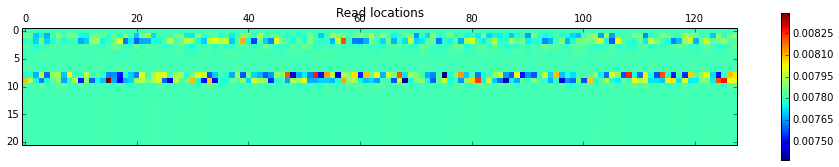

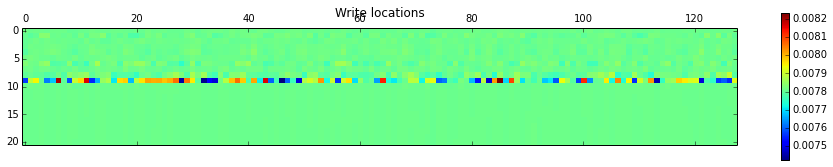

In [107]:
def combine_access(accesses):
    num_accesses = len(accesses)
    assert(num_accesses > 0)
    mem_locations = accesses[0].shape[1]
    res = np.zeros((num_accesses, mem_locations))
    norms = []
    for idx, access in enumerate(accesses):
        assert(access.shape == (1, mem_locations))
        res[idx] = access.w[0]
        norms.append(np.linalg.norm(access.w[0]))
    return res, norms

def inspect(model):
    empty_input      = D.Mat.zeros((1,INPUT_SIZE), constant=True)
    start_prediction = D.Mat.ones((1,INPUT_SIZE), constant=True)
    c = Capture()
    with D.NoBackprop():
        with c:
            example = generate_example(INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH)
            state = model.initial_states()
            for input_vec in example:
                state = model.activate(input_vec, state)

            state = model.activate(start_prediction, state)
            for input_vec in example:
                decoded = np.round(model.decode(state).sigmoid().w)
                state = model.activate(empty_input, state)
    reads, read_norms  = combine_access(c.state["read_head_weights"])
    writes, write_norms = combine_access(c.state["write_head_weights"])

    plt.figure()
    r = plt.matshow(reads)
    plt.title("Read locations")
    plt.colorbar(r)
    
    plt.figure()
    w = plt.matshow(writes)
    plt.title("Write locations")
    plt.colorbar(w)
    
    for idx, (read_n, write_n) in enumerate(zip(read_norms, write_norms)):
        print("At tstep %d READ: %.3f, WRITE: %.3f" % (idx, read_n, write_n))

inspect(ntm_model)

In [63]:
c.state["read_head"][1].shape

(1, 128)

In [80]:
ntm_model.__class__ = NTM
for h in ntm_model.read_heads:
    h.__class__ = NTMReadHead
for h in ntm_model.write_heads:
    h.__class__ = NTMWriteHead

In [47]:
ntm_model.write_heads[0].__class__ = NTMWriteHead

In [4]:
A = D.Mat([[1,1,1],[2,2,2]])
B = D.Mat([[1,2,3]])

In [5]:
print(A.w)
print(B.w)
A/ D.MatOps.broadcast(B, axis=0, num_replicas=2)

[[ 1.  1.  1.]
 [ 2.  2.  2.]]
[[ 1.  2.  3.]]


[
    [  1.000   0.500   0.333]
    [  2.000   1.000   0.667]
]

In [6]:
A.w.mean(axis=0)

array([ 1.5,  1.5,  1.5], dtype=float32)

In [13]:
A.softplus()

[
    [  0.000   1.313   1.313]
    [  2.127   2.127   2.127]
]

In [12]:
A = D.Mat([1,2,3])

In [15]:
D.Mat([1,2,3]) * D.Mat([2])

RuntimeError: Matrices cannot be element-wise multiplied, they do not have the same dimensions.

In [44]:
x = D.random.uniform(-1,1, (1,1)).sum(0)

In [46]:
D.MatOps.broadcast(x, axis=0, num_replicas=20)

[
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
    [ -0.206]
]

In [47]:
x = D.random.uniform(-1,1, (1,2))
y = D.random.uniform(-1,1, (1,3))

In [48]:
x

[
    [  0.405  -0.503]
]

In [49]:
y

[
    [ -0.485   0.607   0.684]
]

[
    [ -0.196   0.244]
    [  0.246  -0.305]
    [  0.277  -0.344]
]

In [51]:
y.dot(x)

RuntimeError: matrix product dimensions misaligned.

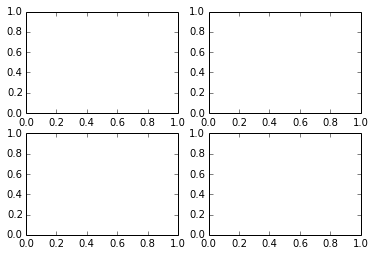

In [99]:
ax = plt.subplots(2,2)

In [100]:
ax

(<matplotlib.figure.Figure at 0x7f02c945bd30>,
 array([[<matplotlib.axes.AxesSubplot object at 0x7f02c9600588>,
         <matplotlib.axes.AxesSubplot object at 0x7f02c9474668>]], dtype=object))